# Introduction

### Notebook by Clark Xu

In this notebook, we analyze large volumes of time series data consisting of database server metrics collected at regular intervals.  The metrics can yield valuable insights into the workloads the database undergoes, which allows us to tune performance and optimize resource utilization.

# The Dataset

### Dataset by MariaDB

The dataset contains a few thousand observations of several hundred status variables (metrics), with each status variable in a separate column.  The column, timestamp, contains the date and time the observation was taken.  

In [1]:
import pandas as pd
import warnings

#Ignore warnings from Pandas
warnings.filterwarnings("ignore")

#Load Dataset into Pandas Dataframe
data = pd.read_csv('benchmark_dataset.csv')
#Check Headers and First Three Rows
data.head(3)

,Aborted_clients,Aborted_connects,Access_denied_errors,Acl_column_grants,Acl_database_grants,Acl_function_grants,Acl_package_body_grants,Acl_package_spec_grants,Acl_procedure_grants,Acl_proxy_users,...,wsrep_cluster_state_uuid,wsrep_cluster_status,wsrep_connected,wsrep_local_bf_aborts,wsrep_local_index,wsrep_provider_name,wsrep_provider_vendor,wsrep_provider_version,wsrep_ready,wsrep_thread_count
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,Disconnected,OFF,0.0,18446744073709551615,NaN,NaN,NaN,OFF,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,Disconnected,OFF,0.0,18446744073709551615,NaN,NaN,NaN,OFF,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,Disconnected,OFF,0.0,18446744073709551615,NaN,NaN,NaN,OFF,0


Now let's check the dimensions of the dataset:

In [2]:
#Summarize Dataset
print("Row Count:",data.shape[0])
print("Column Count:",data.shape[1])

Row Count: 8484
Column Count: 544


And also verify the timestamp column of interest:

In [3]:
#Select Timestamp Column into Pandas Series
timestamp = data.timestamp

#Verify First Three Timestamps
print(timestamp[0:3])

0    2019-04-18 21:06:07.260973
1    2019-04-18 21:06:12.344215
2    2019-04-18 21:06:17.436656
Name: timestamp, dtype: object


# Part 1: Feature Selection

Working with over five hundred features can be computationally expensive, and you will find that not all of them are meaningful.

## Which columns provide useful information?

Describe some criteria to filter down the list of features, apply the criteria to the data, and list the resulting features.

#### Criteria 1: Series should have 2+ unique values

In [4]:
#Criteria 1: Series should have 2+ unique values [filter out dummy data]

##Get Unique Values into Pandas Dataframe
uniqueValues = data.nunique().reset_index()
uniqueValues.columns = ['Column','Count']

##Filter to 2+ unique values
criteria1 = uniqueValues[uniqueValues['Count'] >= 2]
print('Example columns with count of 2+ unique values:')
print(criteria1.head(10))

Example columns with count of 2+ unique values:
               Column  Count
0     Aborted_clients      3
35     Bytes_received   8063
36         Bytes_sent   8065
55      Com_change_db      2
59         Com_commit   6343
61      Com_create_db      4
71   Com_create_table      2
78         Com_delete   5245
107        Com_insert   7669
130      Com_rollback    292


These are the series between 2 and 10 unique values:

In [5]:
##Check 2 to 10 unique values
print('Columns with count of 2 to 10 unique values:')
print(uniqueValues[(uniqueValues['Count'] > 1) & (uniqueValues['Count'] < 10)])

Columns with count of 2 to 10 unique values:
                            Column  Count
0                  Aborted_clients      3
55                   Com_change_db      2
61                   Com_create_db      4
71                Com_create_table      2
134                 Com_set_option      6
147          Com_show_create_table      3
178                Com_show_tables      3
189               Com_stmt_prepare      5
213                    Connections      6
251             Handler_read_first      4
289     Innodb_data_pending_fsyncs      3
290      Innodb_data_pending_reads      3
291     Innodb_data_pending_writes      3
335   Innodb_os_log_pending_fsyncs      3
336   Innodb_os_log_pending_writes      2
344  Innodb_row_lock_current_waits      2
346       Innodb_row_lock_time_avg      9
347       Innodb_row_lock_time_max      9
389                   Opened_files      2
391       Opened_table_definitions      2
417            Prepared_stmt_count      7
466                   Slow_quer

And verify the number of columns after applying Criteria 1:

In [6]:
##Criteria 1 reduced 544 columns to 100 columns
print("Number of Columns With Criteria 1:",criteria1.shape[0])

Number of Columns With Criteria 1: 100


#### Criteria 2: Series should be nonzero at least 5% of the time

In [7]:
#Criteria 2: Series should be nonzero at least 5% of the time [avoid overfitting to rare events]

#Set 'percentage of zeros' threshold to 95%
threshold = 0.95

#Calculate percentage of zeros
missingThreshold = ((data == 0).sum()/data.shape[0]).reset_index()
missingThreshold.columns = ['Column','Zero Percentage']

##Check missingThreshold Dataframe
print('Example columns with percentage of zeros:')
print(missingThreshold.head(10))

Example columns with percentage of zeros:
                    Column  Zero Percentage
0          Aborted_clients         0.999764
1         Aborted_connects         1.000000
2     Access_denied_errors         1.000000
3        Acl_column_grants         1.000000
4      Acl_database_grants         1.000000
5      Acl_function_grants         1.000000
6  Acl_package_body_grants         1.000000
7  Acl_package_spec_grants         1.000000
8     Acl_procedure_grants         1.000000
9          Acl_proxy_users         1.000000


With the percentage of zeros in each column, we set the desired missingness threshold and apply Criteria 2:

In [8]:
##Apply missingThreshold as a boolean mask on Criteria 1 to get Criteria 2
criteria2 = criteria1[missingThreshold['Zero Percentage'] < threshold]

#Check Criteria 2
print('Example columns that are nonzero at least 5% of the time')
print(criteria2.head(10))

Example columns that are nonzero at least 5% of the time
                 Column  Count
35       Bytes_received   8063
36           Bytes_sent   8065
59           Com_commit   6343
78           Com_delete   5245
107          Com_insert   7669
130        Com_rollback    292
133          Com_select   7898
187    Com_stmt_execute   7946
198          Com_update   7739
217  Created_tmp_tables   1681


And verify the number of columns after applying Criteria 2:

In [9]:
##Criteria 2 reduced 100 columns to 77 columns
print("Number of Columns With Criteria 2:",criteria2.shape[0])

Number of Columns With Criteria 2: 77


## What does the filtered data look like?

Any interesting observations?  What is the data trying to tell us?

#### Observation 1: Filtered Data Dimensions and Features

We start data exploration by examining the dimensions of the filtered dataset:

In [10]:
#Apply Criteria 1 & Criteria 2 to Data to make filteredData
filteredData = data.iloc[:,criteria2.index]

#Confirm dimensions of filteredData
print('Filtered number of rows:',filteredData.shape[0])
print('Filtered number of columns:',filteredData.shape[1])

Filtered number of rows: 8484
Filtered number of columns: 77


Next we inspect the filtered column names:

In [11]:
#Check filteredData Column Names
print('Column names:')
print(filteredData.columns)

Column names:
Index(['Bytes_received', 'Bytes_sent', 'Com_commit', 'Com_delete',
       'Com_insert', 'Com_rollback', 'Com_select', 'Com_stmt_execute',
       'Com_update', 'Created_tmp_tables', 'Empty_queries', 'Handler_commit',
       'Handler_delete', 'Handler_icp_attempts', 'Handler_icp_match',
       'Handler_read_key', 'Handler_read_next', 'Handler_read_rnd_deleted',
       'Handler_read_rnd_next', 'Handler_rollback', 'Handler_tmp_write',
       'Handler_update', 'Handler_write', 'Innodb_buffer_pool_bytes_data',
       'Innodb_buffer_pool_bytes_dirty', 'Innodb_buffer_pool_pages_data',
       'Innodb_buffer_pool_pages_dirty', 'Innodb_buffer_pool_pages_flushed',
       'Innodb_buffer_pool_pages_free', 'Innodb_buffer_pool_pages_misc',
       'Innodb_buffer_pool_read_requests', 'Innodb_buffer_pool_reads',
       'Innodb_buffer_pool_write_requests', 'Innodb_data_fsyncs',
       'Innodb_data_pending_fsyncs', 'Innodb_data_pending_writes',
       'Innodb_data_read', 'Innodb_data_reads', 

#### Observation 2: Feature Distributions

To assist with data exploration, we sketch the distribution of each filtered column:

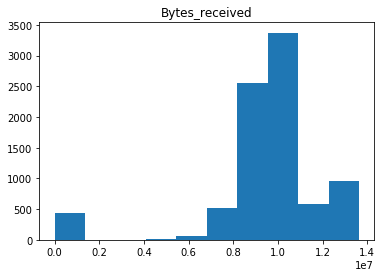

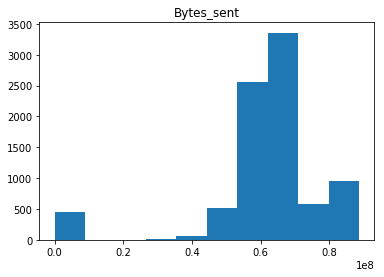

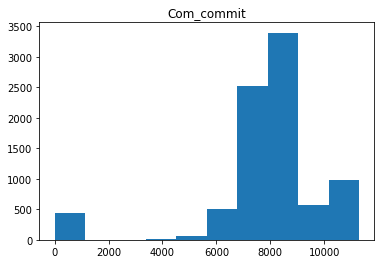

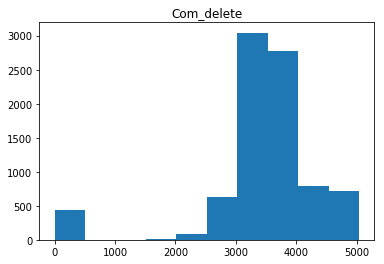

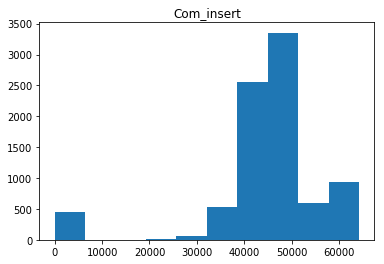

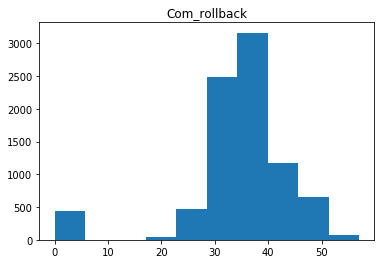

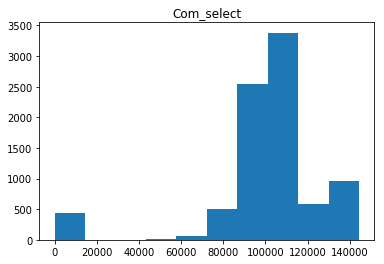

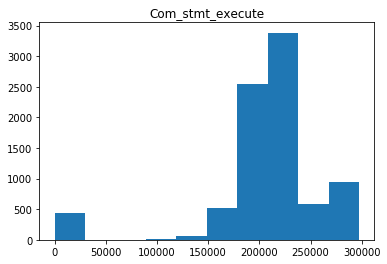

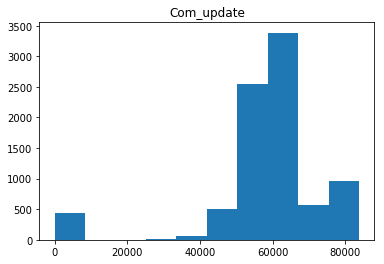

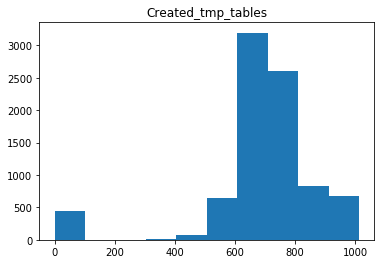

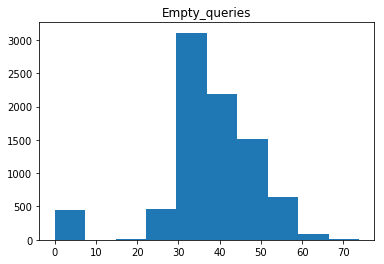

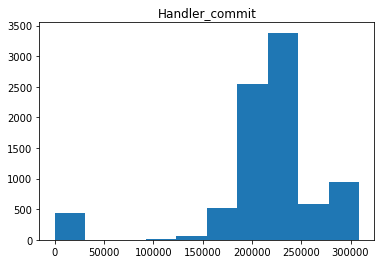

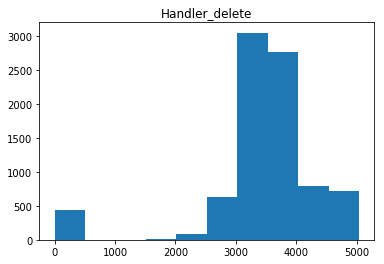

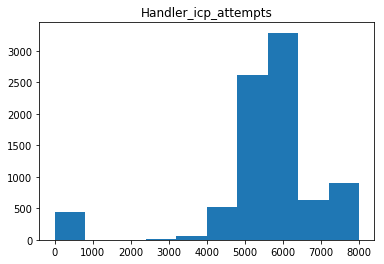

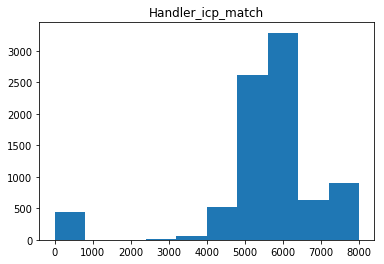

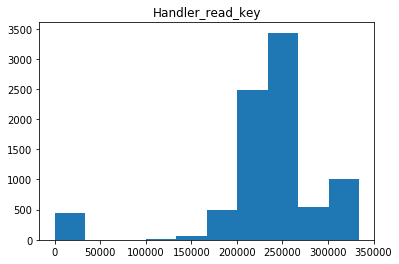

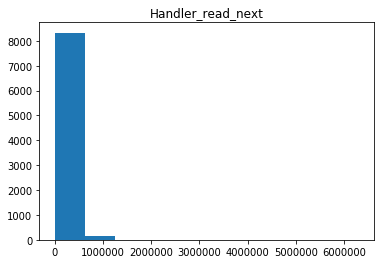

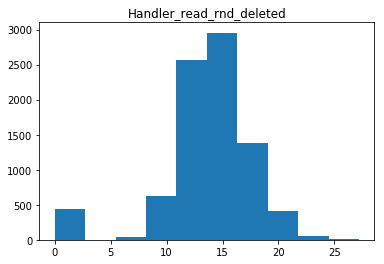

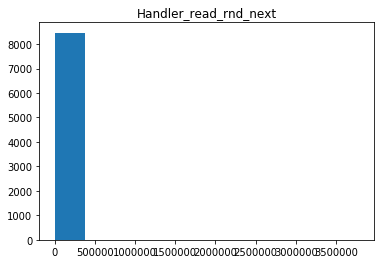

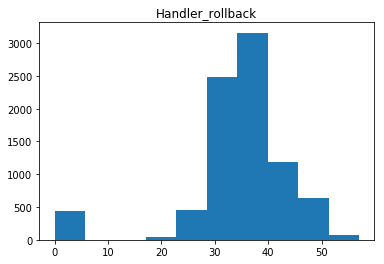

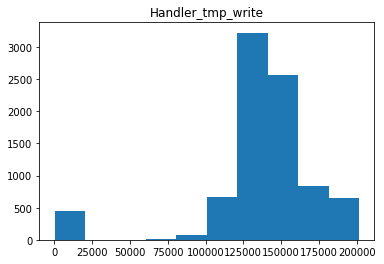

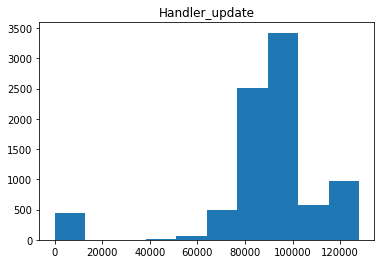

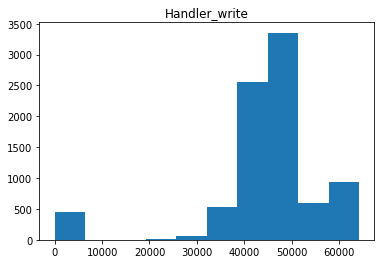

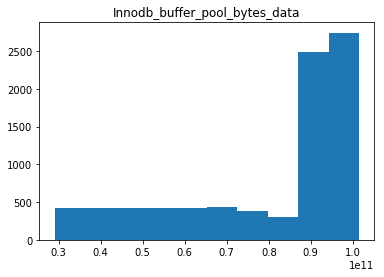

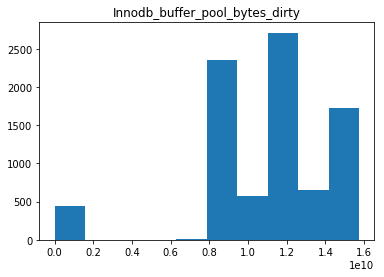

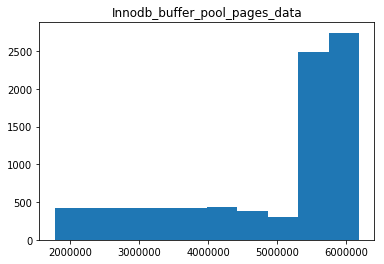

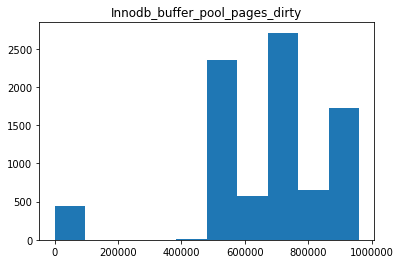

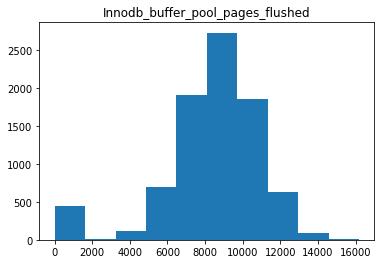

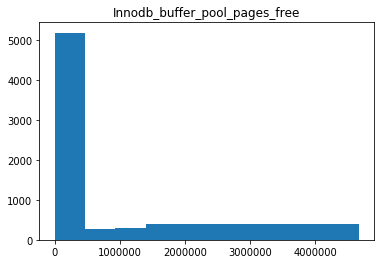

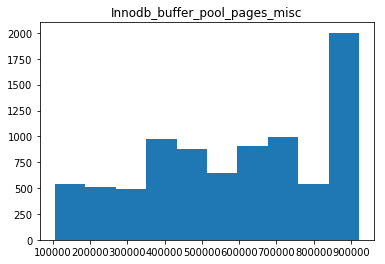

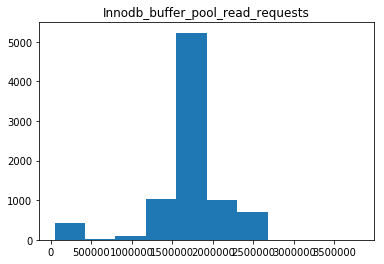

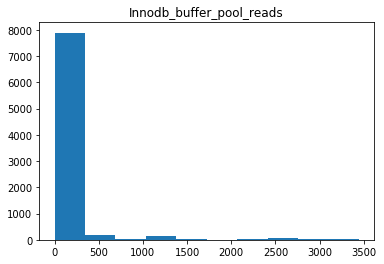

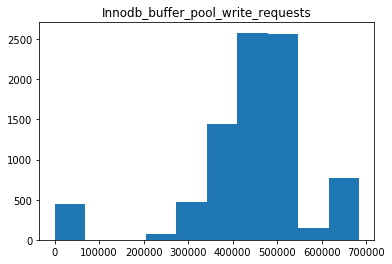

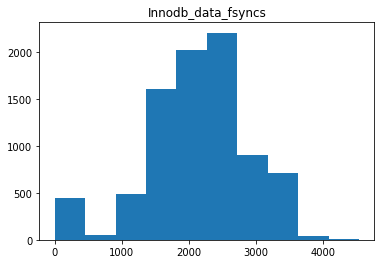

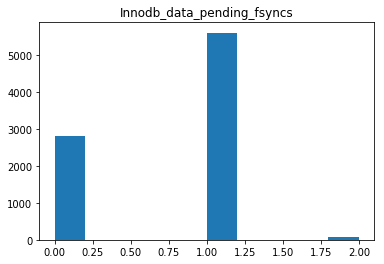

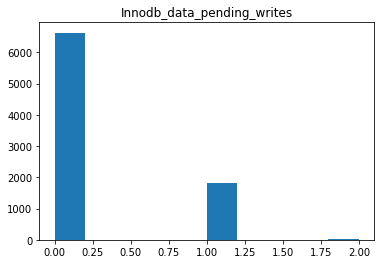

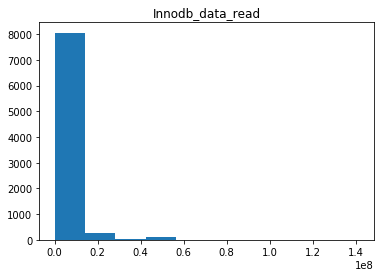

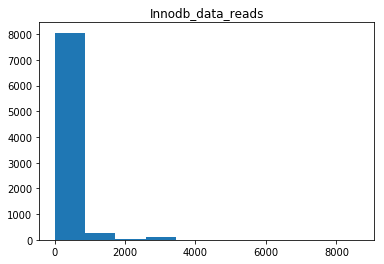

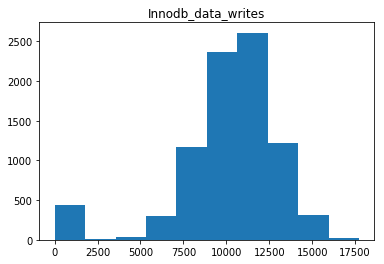

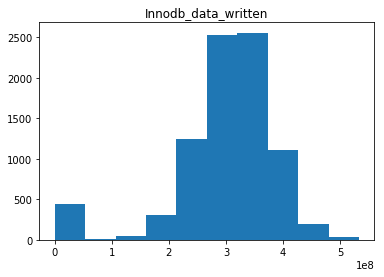

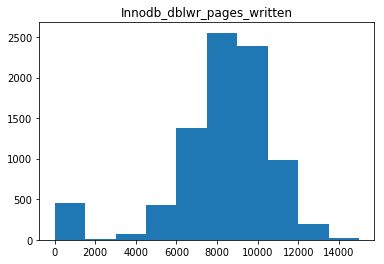

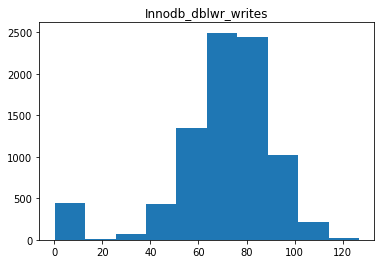

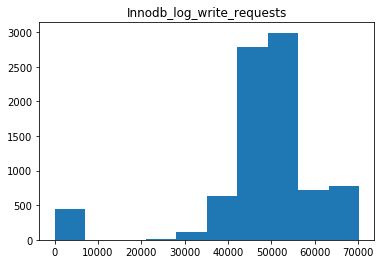

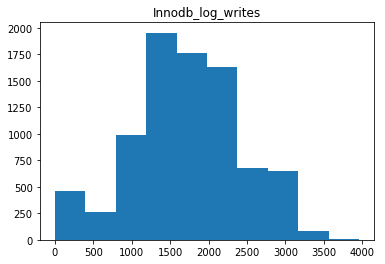

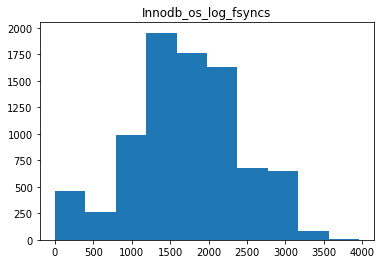

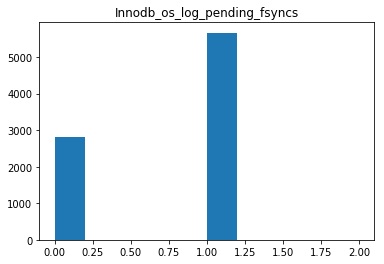

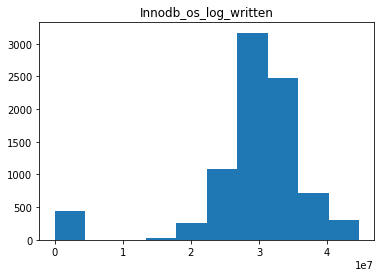

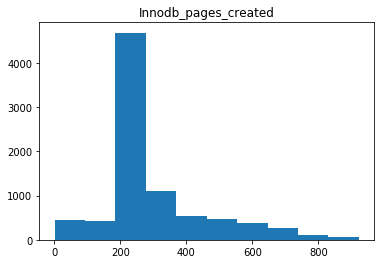

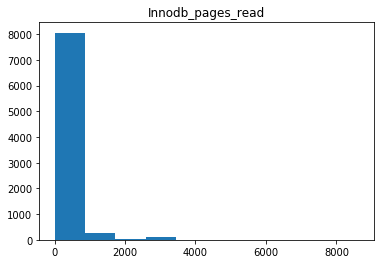

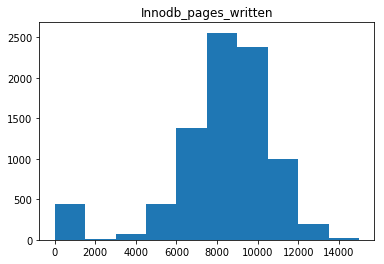

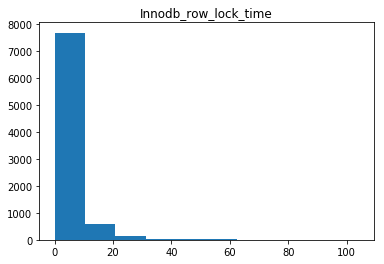

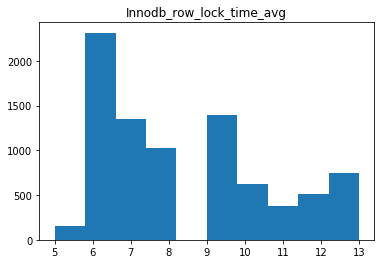

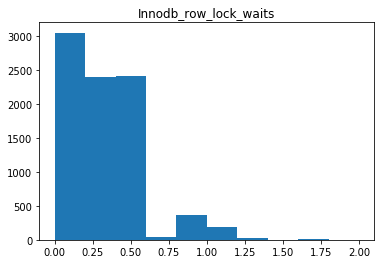

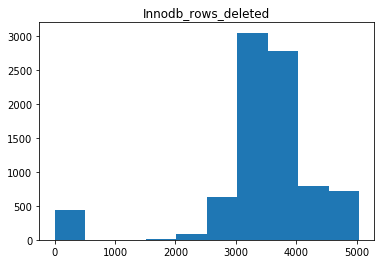

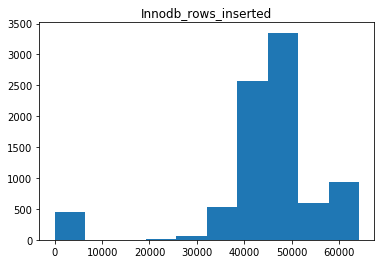

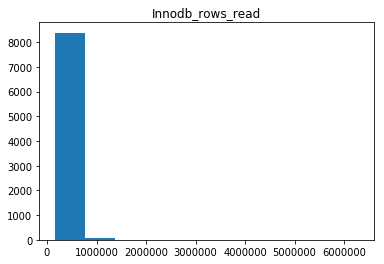

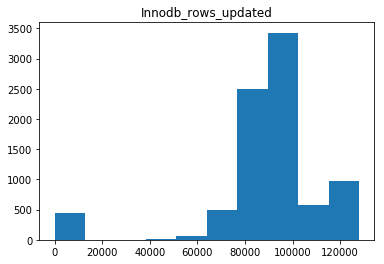

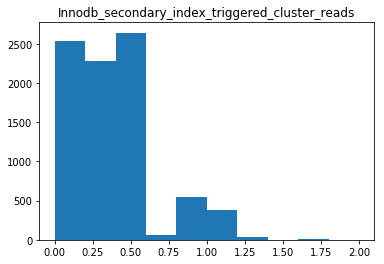

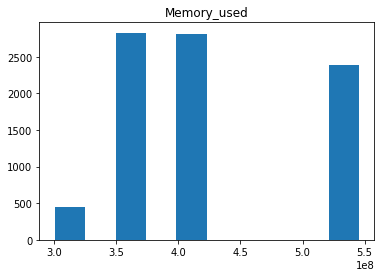

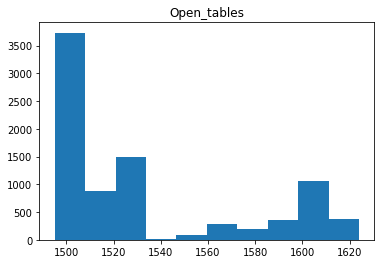

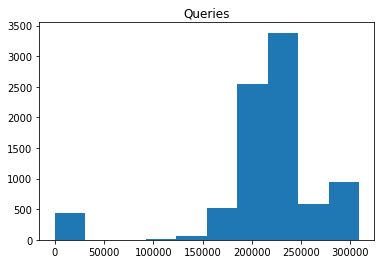

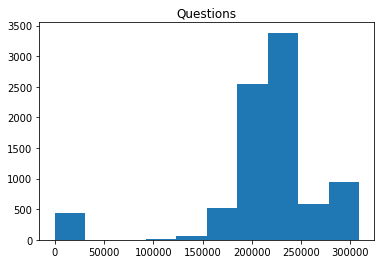

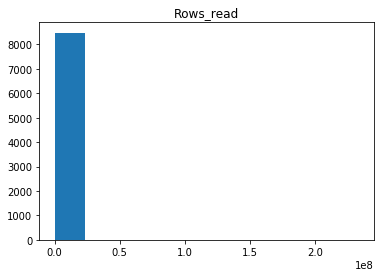

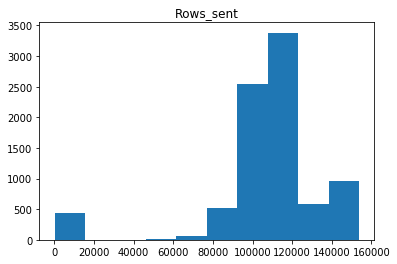

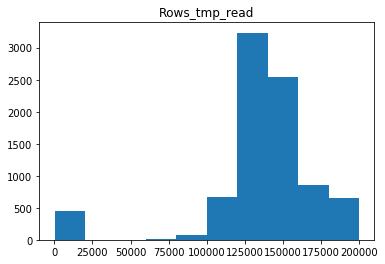

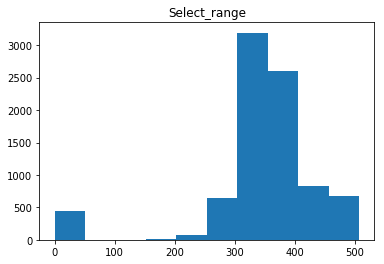

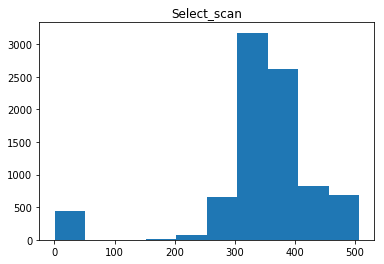

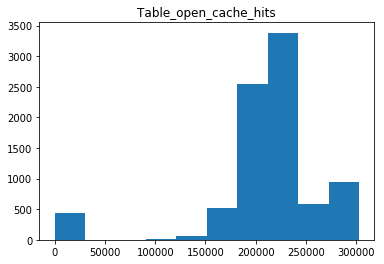

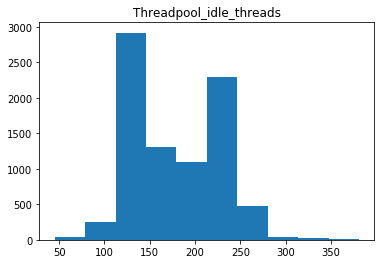

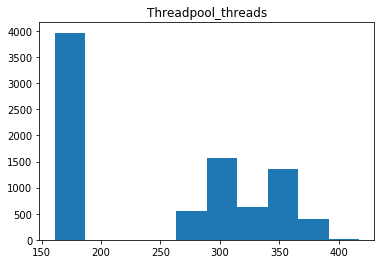

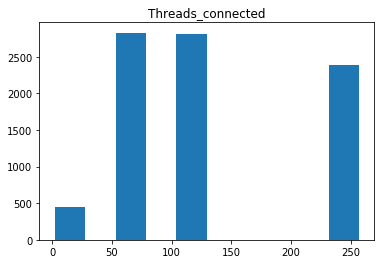

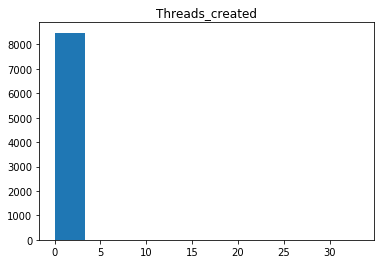

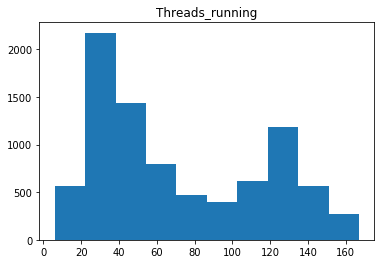

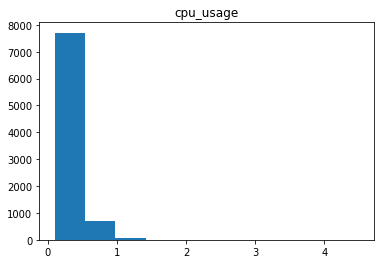

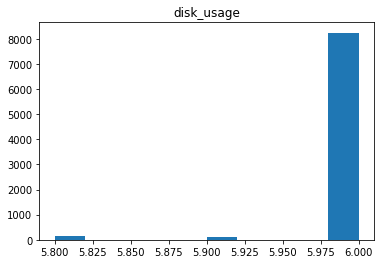

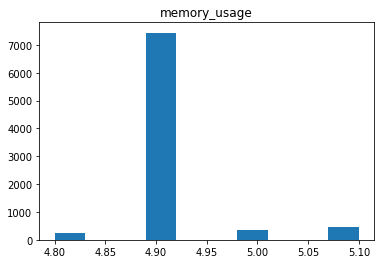

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

#Record Column Data
columnData = []

#Plot histograms for all filteredData columns
for column in filteredData.columns:
    #Add Column Name to columnData
    columnData.append(column.replace('_',' '))
    #Ignore Timestamp
    if column != 'timestamp':
        #Create histogram of column
        plt.figure()
        plt.hist(filteredData[column])
        plt.title(column)
        plt.show()

We observe normal, uniform, and exponential distribution as the most common among the filtered columns.

#### Observation 3: Feature Importance Ranking

Taking a domain agnostic approach, we now use TF-IDF (Term Frequency, Inverse Document Frequency) algorithm to semantically analyze the most important column names among the filtered columns:

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Make Bag of Words from Column Data
bagOfWords = [' '.join(columnData)]

#Apply TF-IDF
tfIdfVectorizer = TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(bagOfWords)

#Convert TF-IDF Output to conceptList Dataframe
conceptList = pd.DataFrame(tfIdf[0].T.todense(),index=tfIdfVectorizer.get_feature_names(),columns=["TF-IDF"])
#Sort conceptList by TF-IDF Score
conceptList = conceptList.sort_values('TF-IDF',ascending=False)
#Show Top 30 Concepts
print(conceptList.head(30))

            TF-IDF
innodb    0.738029
handler   0.253038
buffer    0.210865
read      0.210865
pool      0.210865
data      0.189779
pages     0.189779
rows      0.147606
com       0.147606
log       0.105433
threads   0.105433
written   0.084346
fsyncs    0.084346
write     0.084346
writes    0.084346
bytes     0.084346
lock      0.063260
reads     0.063260
requests  0.063260
pending   0.063260
select    0.063260
row       0.063260
created   0.063260
tmp       0.063260
usage     0.063260
os        0.063260
rollback  0.042173
rnd       0.042173
next      0.042173
sent      0.042173


We plot the ten most important words with their associated TF-IDF scores:

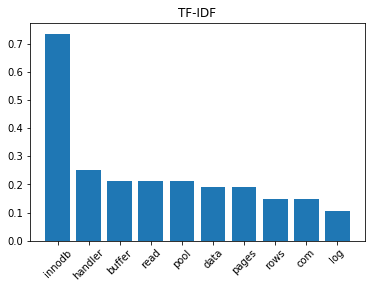

In [14]:
#Visualize TF-IDF
##Select column and row
column = 'TF-IDF'
row = 10
##Configure bar chart
plt.figure()
plt.bar(conceptList.index[0:row],conceptList[column][0:row])
plt.xticks(rotation=45)
plt.title(column)
plt.show()

Some important words in the corpus include innodb, which seems specific to the dataset. Other words such as handler, buffer, read we would expect to be important in a database metrics dataset. The TF-IDF algorithm provides a domain-agnostic way to pull out the most important processes in the database.

#### Observation 4: Feature Correlation

**Usage:** Let's first investigate the correlation among the usage columns:

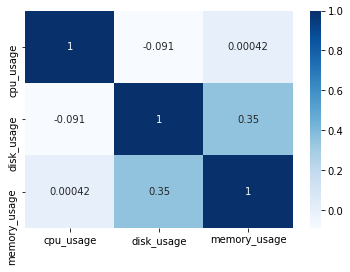

In [15]:
import seaborn as sns

#Visualize Correlation Heatmap
ax = sns.heatmap(filteredData[['cpu_usage','disk_usage','memory_usage']].corr(),annot=True,cmap="Blues")

We see a moderate correlation between memory and disk usage, but no correlation among any of the other usages.

**Thread:** Now we investigate the correlatoin among the thread columns:

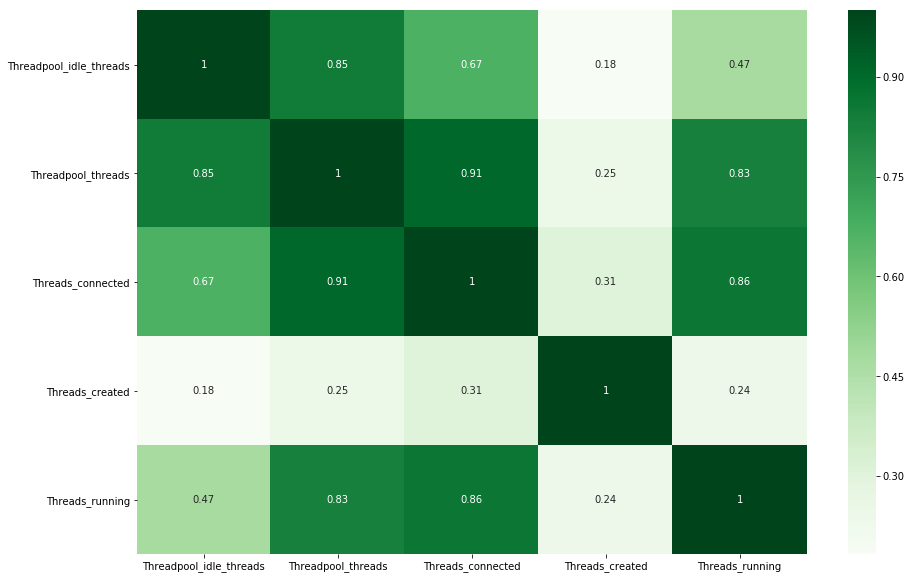

In [16]:
#Increase Heatmap Size with Seaborn Context
plt.figure(figsize = (15,10))

#Visualize Correlation Heatmap
ax = sns.heatmap(filteredData[['Threadpool_idle_threads'
                              ,'Threadpool_threads'
                              ,'Threads_connected'
                              ,'Threads_created'
                              ,'Threads_running']].corr(),annot=True,cmap="Greens")

Some important relationships we observe:

(1) Threads created has low correlation with the other threads columns.

(2) Threadpool idle threads, threadpool threads, and threads connected all have high inter-correlation.

**Com:** Next we investigate the com columns:

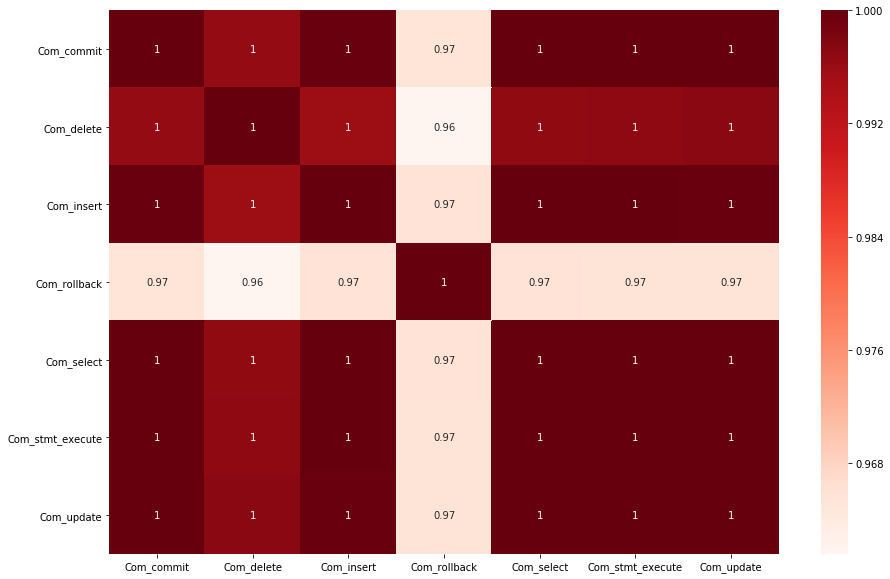

In [17]:
#Increase Heatmap Size with Seaborn Context
plt.figure(figsize = (15,10))

#Visualize Correlation Heatmap
ax = sns.heatmap(filteredData[['Com_commit'
                              ,'Com_delete'
                              ,'Com_insert'
                              ,'Com_rollback'
                              ,'Com_select'
                              ,'Com_stmt_execute'
                              ,'Com_update']].corr(),annot=True,cmap="Reds")

Com Rollback is the only Com column which differs from the others. If we need to further filter the dataset, we might want to collapse columns that have correlation of 1.

**Handler:** Finally we check the handler columns:

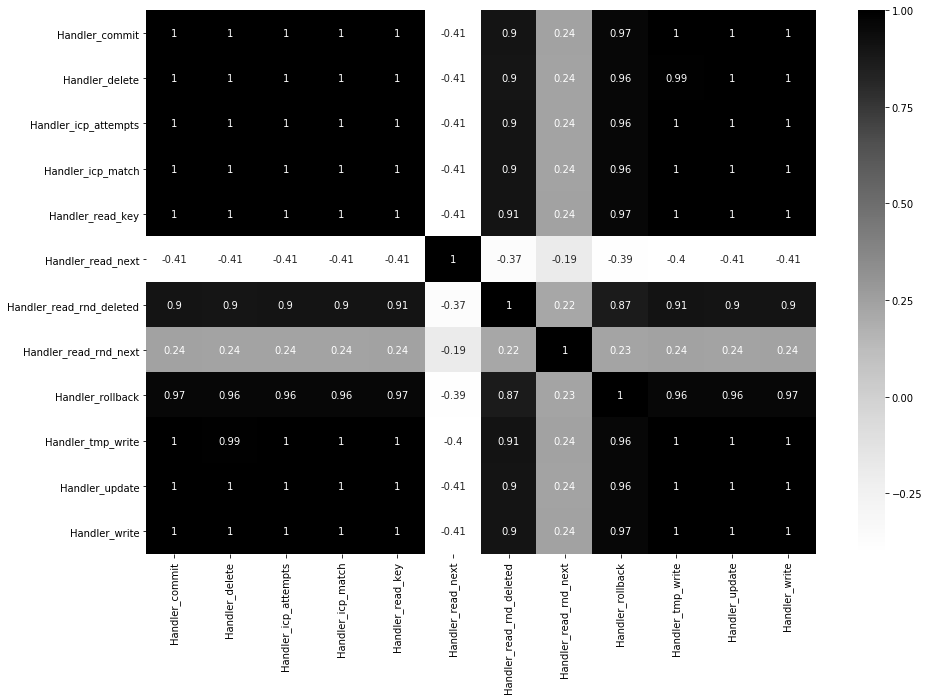

In [18]:
#Increase Heatmap Size with Seaborn Context
plt.figure(figsize = (15,10))

#Visualize Correlation Heatmap
ax = sns.heatmap(filteredData[['Handler_commit'
                              ,'Handler_delete'
                              ,'Handler_icp_attempts'
                              ,'Handler_icp_match'
                              ,'Handler_read_key'
                              ,'Handler_read_next'
                              ,'Handler_read_rnd_deleted'
                              ,'Handler_read_rnd_next'
                              ,'Handler_rollback'
                              ,'Handler_tmp_write'
                              ,'Handler_update'
                              ,'Handler_write']].corr(),annot=True,cmap="Greys")

We find that handler read next and handler read rnd next are the Handler columns which differ from the others.

**All:** For later reference, we also show all of the correlations among the filtered columns:

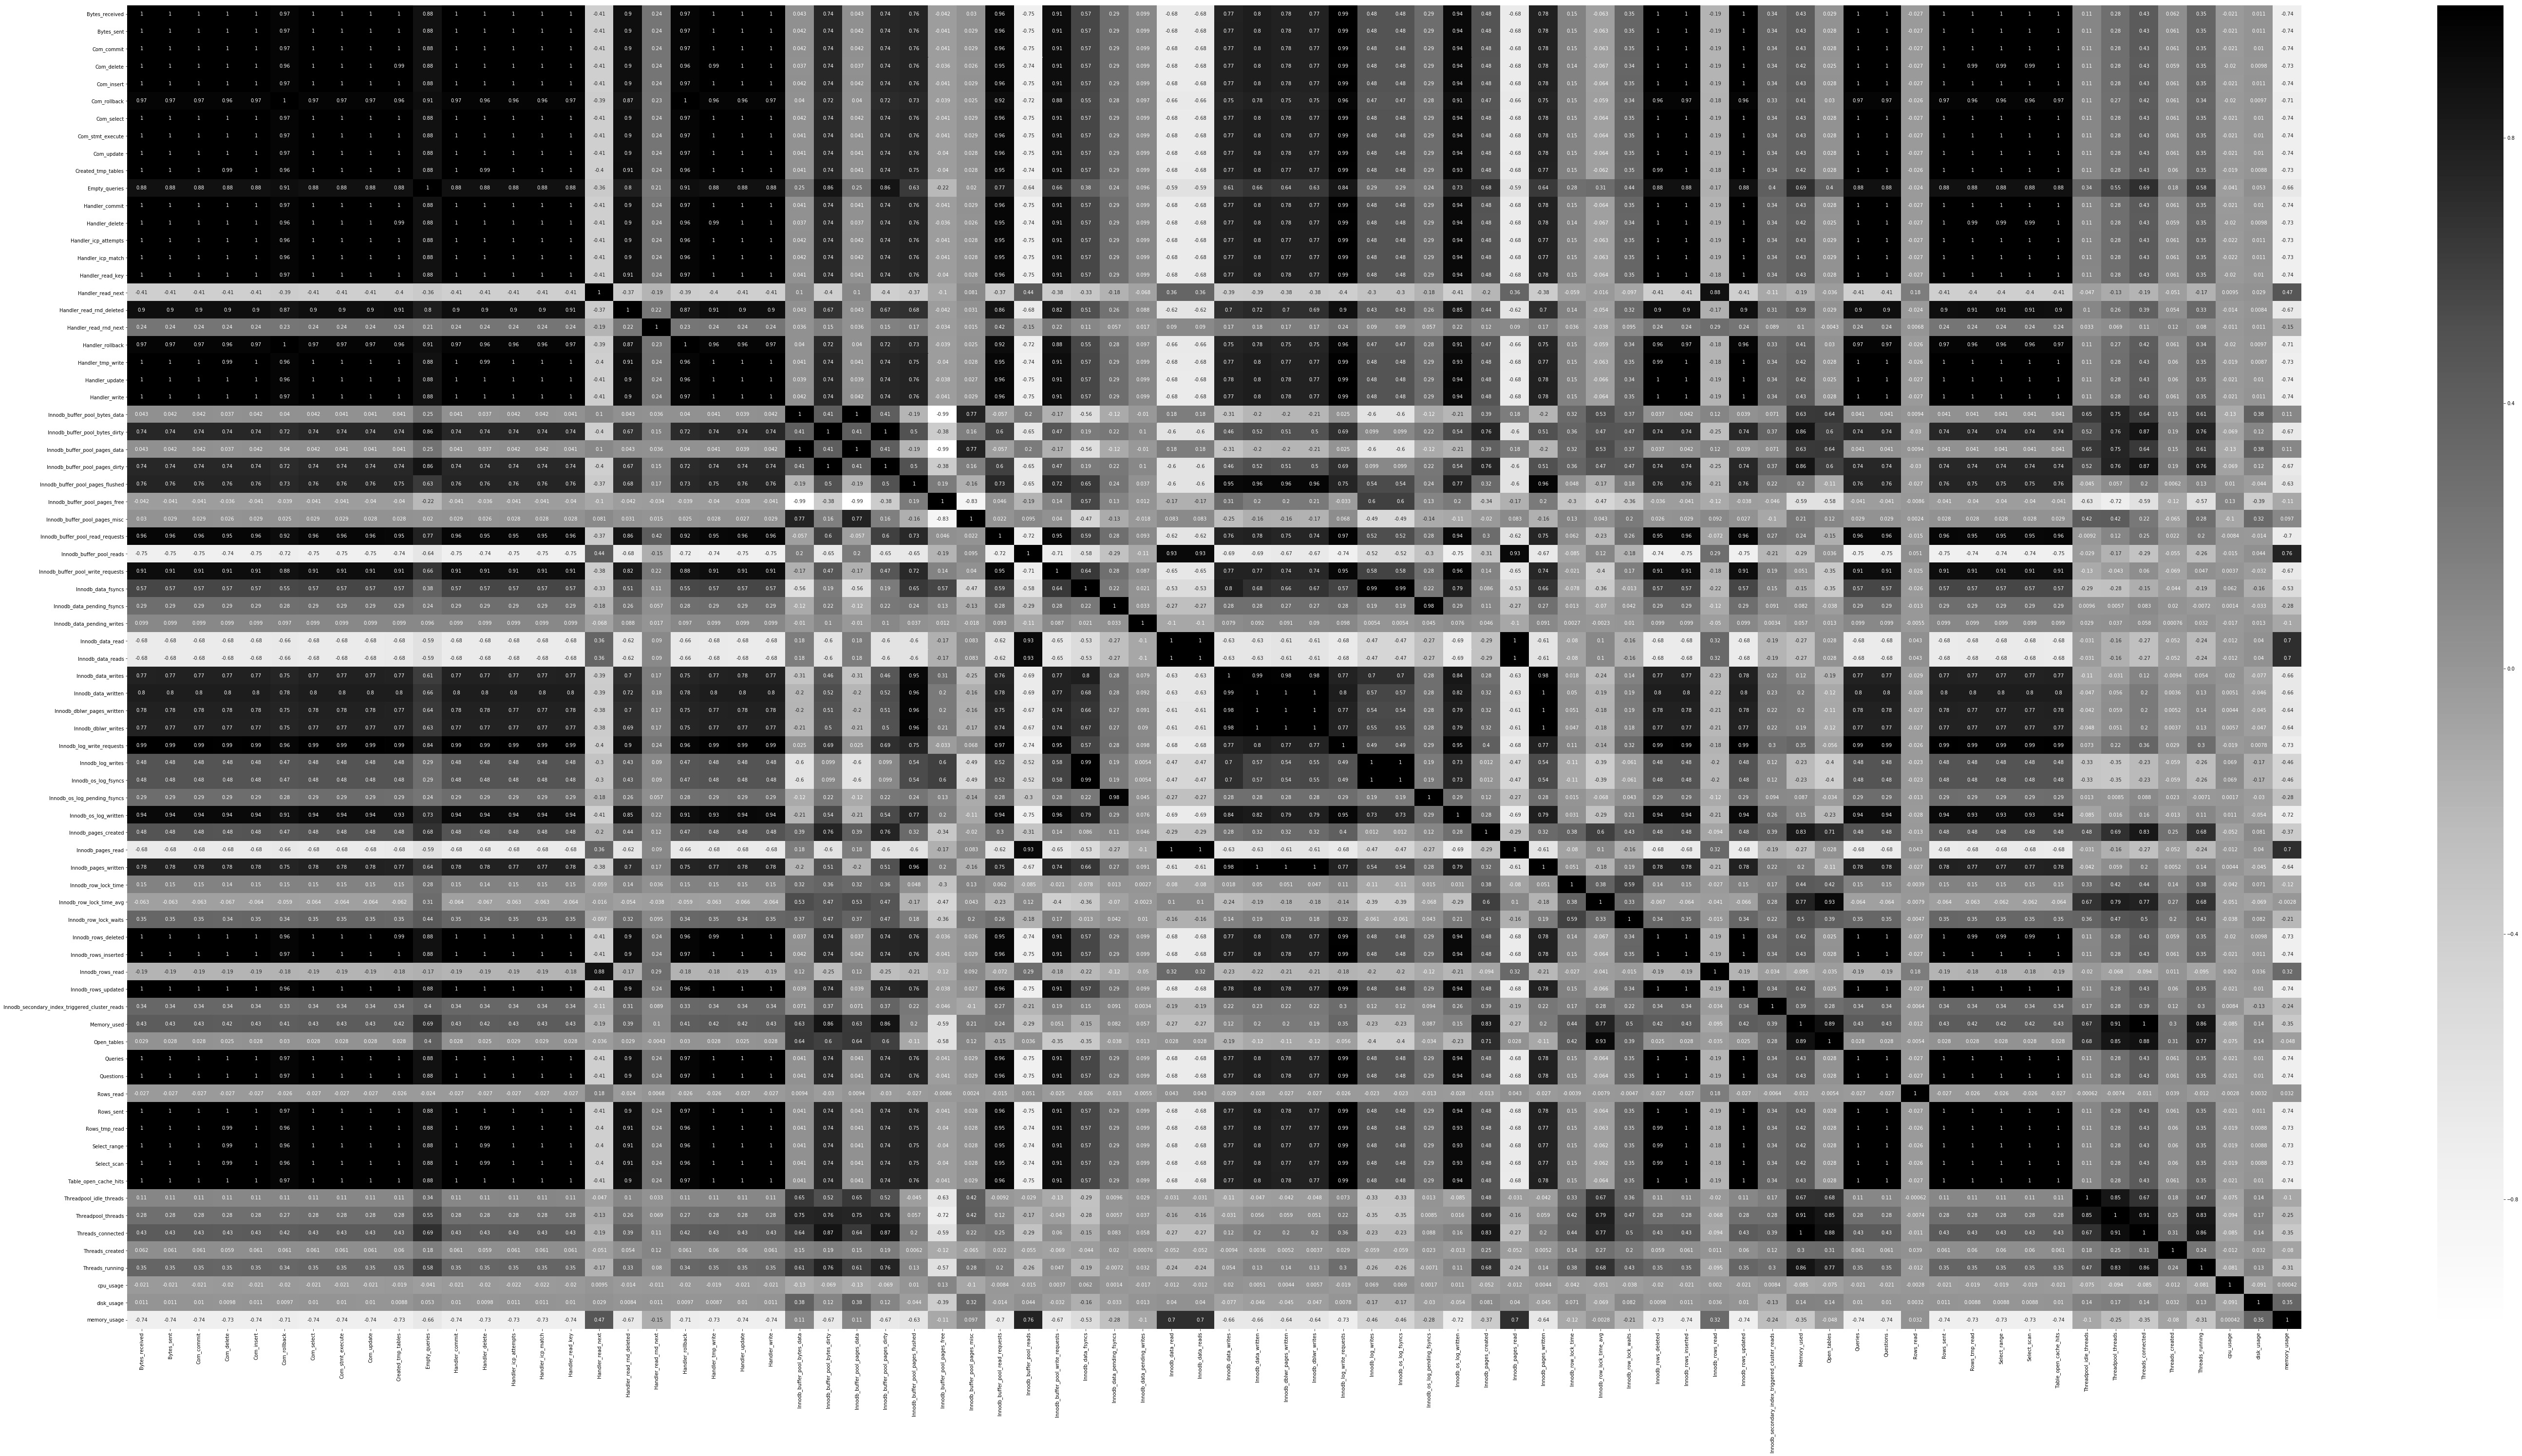

In [19]:
#Increase Heatmap Size with Seaborn Context
plt.figure(figsize = (100,50))

#Visualize Correlation Heatmap
ax = sns.heatmap(filteredData.corr(),annot=True,cmap="Greys")

#### Observation 5: Feature Relationships

First we define a helper function to simplify the code:

In [20]:
def fmtStr(string):
    """
    Input: string to format
    Output: formatted string
    """
    stringOut = string.replace('_',' ')
    return stringOut

def scatterPlot(dataframe,series1,series2):
    """
    Input:
    dataframe - Name of Pandas Dataframe containing series1 and series2
    series1 - Pandas Series representing Dimension 1
    series2 - Pandas Series representing Dimension 2
    Output:
    Scatterplot of series1 against series2 with title and axis labels
    """
    #Choose Series for Scatter Plot
    plt.scatter(series1,series2)
    plt.plot()

    #Format Scatter Plot
    plt.title(fmtStr(series1.name)+" vs "+fmtStr(series2.name))
    plt.xlabel(fmtStr(series1.name))
    plt.ylabel(fmtStr(series2.name))
    plt.show()

Extending the analysis of feature correlation, we graph some of the relationships:

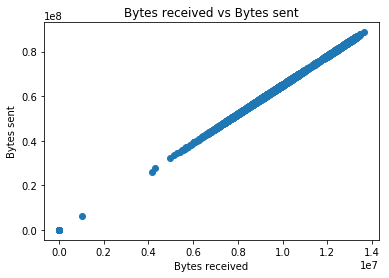

In [21]:
#Scatter Plot of Bytes
scatterPlot(filteredData,filteredData.Bytes_received,filteredData.Bytes_sent)

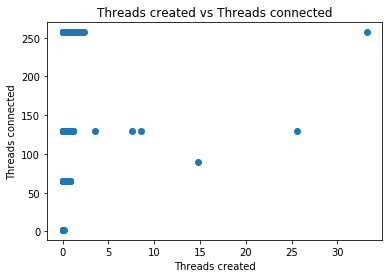

In [22]:
#Scatter Plot of Threads
scatterPlot(filteredData,filteredData.Threads_created,filteredData.Threads_connected)

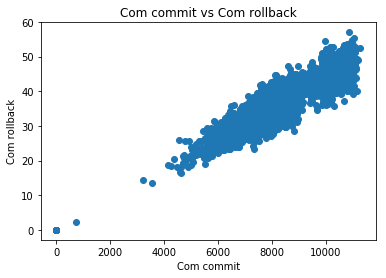

In [23]:
#Scatter Plot of Com
scatterPlot(filteredData,filteredData.Com_commit,filteredData.Com_rollback)

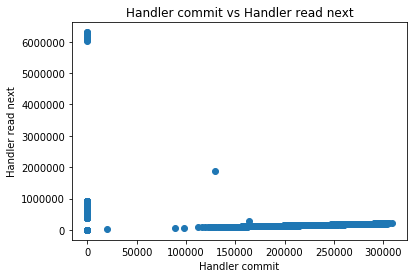

In [24]:
#Scatter Plot of Hadnles
scatterPlot(filteredData,filteredData.Handler_commit,filteredData.Handler_read_next)

## Part 2: Processing

Now it’s time to prepare the data for model building. Most time series models require some context to be useful rather than taking a single observation as input.

### Identify gaps


If you look closely at the data, you’ll find that while most observations appear at regular intervals, there are some gaps. This can present problems later in the pipeline. 

Write a function that assigns a unique id to all groups of contiguous data, where “contiguous” means all the observations within the group are no more than max_time_gap seconds apart:

In [25]:
from datetime import datetime, timedelta

def assign_groups(df, max_time_gap, group_col='group_id'):
    """
    Input:
    df - input data as a pandas data frame
    max_time_gap - maximum time in seconds between observations
    group_col - destination column containing the assigned group ids
    Output:
    df - output data including group_col as a pandas data fame
    """
    #Initialize ID
    counter = 1
    #Store previous row
    prev_row = None
    #Initialize destination column as series
    dest = pd.Series()
    #Name destination column
    dest.name = group_col
    
    #Iterate through timestamps
    for row in df.timestamp:
        #Get time difference if applicable
        if prev_row != None:
            #Get current and previous row into datetime from string
            rowTime = datetime.strptime(row,'%Y-%m-%d %H:%M:%S.%f')
            prevRowTime = datetime.strptime(prev_row,'%Y-%m-%d %H:%M:%S.%f')
            
            #Calculate datetime diff
            diff = rowTime - prevRowTime
            
            #Increase counter if new group
            if diff > timedelta(seconds=max_time_gap):
                counter +=1
        
        #Assign ID counter to row in destination column
        dest.at[row] = counter
        
        #Store row as previous row
        prev_row = row
        
    #Update dataframe with destination column
    df[group_col] = dest.values
    #Return updated dataframe
    return df

Run your function on the data.  How many distinct groups are there if we use a max_time_gap of 5 seconds? 10 seconds? 10 minutes?

**5 seconds:**

In [26]:
#Assign groups with max_time_gap of 5 seconds
gap5 = assign_groups(filteredData,5)

In [27]:
print("With max_time_gap of 5 seconds we have distinct groups:",gap5["group_id"].max())

With max_time_gap of 5 seconds we have distinct groups: 8484


**10 seconds:**

In [28]:
#Assign groups with max_time_gap of 10 seconds
gap10 = assign_groups(filteredData,10)

In [29]:
print("With max_time_gap of 10 seconds we have distinct groups:",gap10["group_id"].max())

With max_time_gap of 10 seconds we have distinct groups: 3


**600 seconds (10 minutes):**

In [30]:
#Assign groups with max_time_gap of 600 seconds (10 minutes)
gap600 = assign_groups(filteredData,600)

In [31]:
print("With max_time_gap of 600 seconds (10 minutes) we have distinct groups:",gap600["group_id"].max())

With max_time_gap of 600 seconds (10 minutes) we have distinct groups: 1


### Prepare the data

Write a function that takes as input the 2D data with shape (samples, features) and outputs a 3D matrix of shape (samples, timesteps, features) that represents a vector of the previous “timesteps” observations for each feature at a given sample of time.  The function needs to respect group boundaries so that we do not get misleading vectors of feature values. 

In [32]:
import numpy as np

def prep_data(df,timesteps):
    """
    Input:
    df - input data as a pandas data frame with 2D shape (samples,features)
    timesteps - number of previous observatrions for each feature at a given sample of time
    Output:
    output - output data as a numpy array with 3D shape (samples,timesteps,features)
    """
    #Initialize output list
    output = []
    #Initialize minimum index and maximum index
    minI,maxI = timesteps,len(df)-1
    #Initialize group_id
    current_group_id = 1
    #Get group_id column index
    colI = df.columns.get_loc('group_id')
    
    #Iterate while counter does not exceed maximum index
    while not( (minI+timesteps) > maxI ):
        #Get the group_id of the row
        row_group_id = df.iloc[minI,colI]
        #Respect group boundaries
        if row_group_id == current_group_id:
            #Slice from current row back by timesteps
            timeSeries = df.loc[minI-timesteps:minI]
            timeSlice = []
            
            #Iterate by step in timestep
            for step in range(timesteps+1):
                #Append row to matrix by step
                timeSlice.append(np.array(timeSeries.iloc[step]))
            
            #Add to output
            output.append(np.array(timeSlice))
        
        #Increase counter by timesteps
        minI += timesteps
        #Update current_group_id
        current_group_id = row_group_id
    #Return updated dataframe
    return np.array(output)

In [33]:
#Assign groups with max_time_gap of 10 seconds
gap10 = assign_groups(filteredData,10)
#Narrow filteredData with max_time_gap of 5 seconds to a testDF
testDF = gap10[['Bytes_received','Bytes_sent','timestamp','group_id']]
#Run prep_data function with testDF
result = prep_data(testDF,2)

In [34]:
#Show example output
print(result)

[[[10561620.2 68704539.4 '2019-04-18 21:06:07.260973' 1]
  [10500999.8 68209518.4 '2019-04-18 21:06:12.344215' 1]
  [10447526.2 67962217.8 '2019-04-18 21:06:17.436656' 1]]

 [[10447526.2 67962217.8 '2019-04-18 21:06:17.436656' 1]
  [10469683.6 68145140.0 '2019-04-18 21:06:22.525223' 1]
  [10458695.2 67994582.2 '2019-04-18 21:06:27.622103' 1]]

 [[10458695.2 67994582.2 '2019-04-18 21:06:27.622103' 1]
  [10504601.4 68303139.6 '2019-04-18 21:06:32.725557' 1]
  [10394674.8 67679100.6 '2019-04-18 21:06:37.823348' 1]]

 ...

 [[10711657.0 69611386.8 '2019-04-19 09:15:16.562235' 3]
  [10737967.2 69951322.6 '2019-04-19 09:15:21.656964' 3]
  [10727349.6 69732286.6 '2019-04-19 09:15:26.747255' 3]]

 [[10727349.6 69732286.6 '2019-04-19 09:15:26.747255' 3]
  [10663657.6 69272261.0 '2019-04-19 09:15:31.843029' 3]
  [10459419.0 67689396.8 '2019-04-19 09:15:36.928517' 3]]

 [[10459419.0 67689396.8 '2019-04-19 09:15:36.928517' 3]
  [10483307.2 68123660.6 '2019-04-19 09:15:42.019833' 3]
  [8936871.0 58

In [35]:
#Show example output dimensions
print("Samples:",result.shape[0],"Timesteps:",result.shape[1],"Features:",result.shape[2])

Samples: 4238 Timesteps: 3 Features: 4


## Part 3: Clustering
How would you programmatically cluster the data into blocks of time that have similar feature characteristics?  Provide the code for your solution below and visualize the resulting clusters.  How would you assess whether the approach is effective?

### Cluster the Data
We use prep_data() from Part II on the filtered data with max_time_gap of 10 seconds.

In [36]:
clusters = prep_data(gap10,1)

From the previous analysis, we expect three clusters which are similar in timestamp.

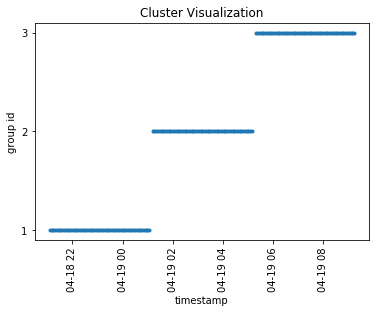

In [37]:
#Ignore warnings from Pandas
warnings.filterwarnings("ignore")

#Initialize lists
x = []
y = []

#Iterate by cluster and timestep
for cluster in clusters:
    for step in cluster:
        #Add entries to lists
        x.append(datetime.strptime(step[-2],'%Y-%m-%d %H:%M:%S.%f'))
        y.append(step[-1])
        
#Choose Plot Values
plt.plot(x[::100],y[::100],'.')
#Format Plot
plt.locator_params(which="both",tight=True,nbins=2)
plt.xticks(rotation=90)
plt.xlabel(fmtStr(gap10.columns[-2]))
plt.ylabel(fmtStr(gap10.columns[-1]))
plt.title('Cluster Visualization') 
plt.show()

We have verified that the clusters are grouping as expected.

### Visualize the Clusters

Now we visualize the timestamp clusters by group id against various features of interest using a helper function.

In [38]:
def timeSeriesPlot(dataframe,column1,column2,bins):
    """
    Input:
    dataframe - Name of Pandas Dataframe containing column1 and column2
    column1 - Column Name representing Dimension 1
    column2 - Column Name representing Dimension 2
    bins - Set x_bins
    Output:
    Scatterplot of column1 against column2 with legend and axis labels
    """
    #Consider two columns by group id and select columns
    data = dataframe[[column1,column2,'group_id']]
    #Format scatterplot
    #Show scatterplot of selected columns 
    graph = sns.lmplot(data=data,x=column1,y=column2,hue='group_id',fit_reg=False,legend=True,legend_out=True,x_bins=bins,palette="Set2")

We first examine rollbacks against commit by timestamp group id:

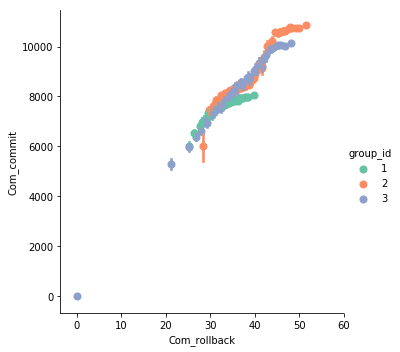

In [39]:
#Check rollback vs commit
timeSeriesPlot(gap10,'Com_rollback','Com_commit',50)

We find outliers in handler read next against handler commit in groups 2 and 3 but not 1:

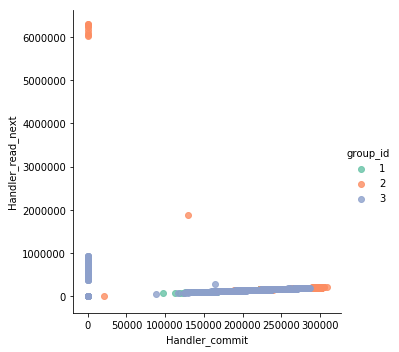

In [40]:
#Check commit vs read next
timeSeriesPlot(gap10,'Handler_commit','Handler_read_next',None)

Examining further, we see that group 1 has a higher peak in cpu usage by handler commit, which corresponds to relatively lower disk usage and more variation in memory usage, relative to the other groups 2 and 3:

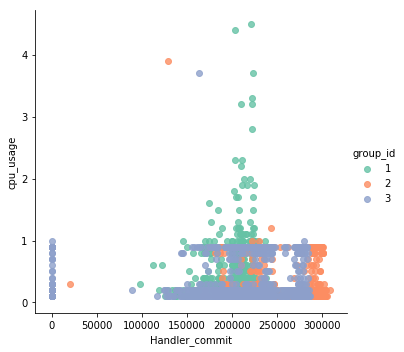

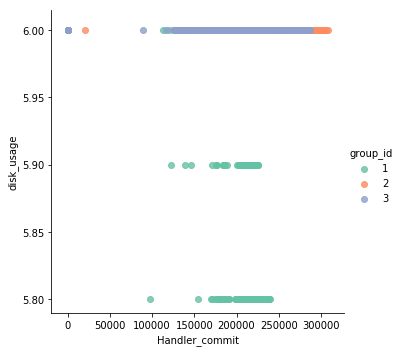

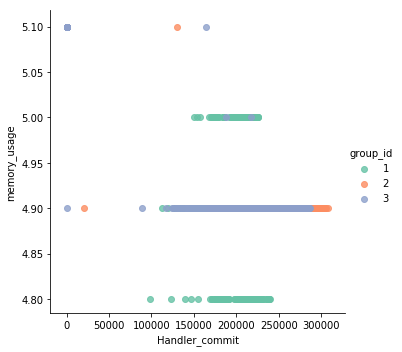

In [41]:
#Check commit vs usage (cpu,disk,memory)
timeSeriesPlot(gap10,'Handler_commit','cpu_usage',None)
timeSeriesPlot(gap10,'Handler_commit','disk_usage',None)
timeSeriesPlot(gap10,'Handler_commit','memory_usage',None)